In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

img_height=48
img_width=48

In [149]:
train_dir = 'Data/train/'
test_dir = 'Data/test/'

def dataf(path, set_):
    dict_ = {}
    for exp in os.listdir(path):
        if exp not in ['disgust','fear', 'surprise']:
            dir_ = path + exp
            dict_[exp] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = dataf(train_dir, 'train')
test_count = dataf(test_dir, 'test')

In [150]:
print(train_count.columns)
print(test_count)

Index(['angry', 'happy', 'neutral', 'sad'], dtype='object')
      angry  happy  neutral   sad
test    958   1774     1233  1247


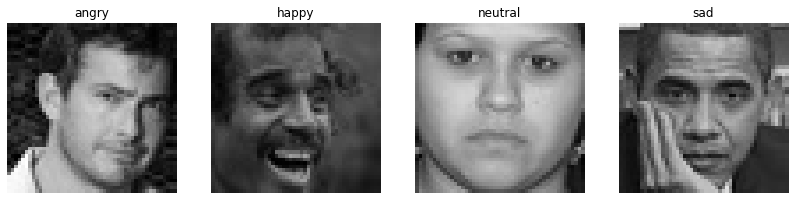

In [151]:
plt.figure(figsize=(14,22))
count = 1
for exp in train_count.columns:
    img = load_img((train_dir + exp +'/'+ os.listdir(train_dir + exp)[1]))
    plt.subplot(1,4,count)
    plt.imshow(img)
    plt.title(exp)
    plt.axis('off')
    count += 1
    
plt.show()

In [152]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   rotation_range=-20,
                                   brightness_range=[0.2,0.8],
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')


test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 21005 images belonging to 4 classes.
Found 5212 images belonging to 4 classes.


In [153]:
training_set.class_indices

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}

In [132]:
resize_rescale = tf.keras.Sequential([
           tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
           tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
           tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [133]:
img = load_img((train_dir + 'sad' +'/'+ os.listdir(train_dir + 'sad')[1]))
re_img=tf.keras.preprocessing.image.img_to_array(img)
results = resize_rescale(re_img)
results.shape

TensorShape([48, 48, 3])

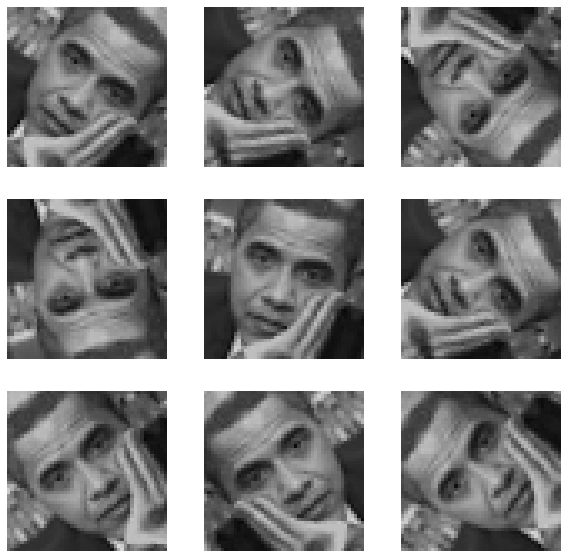

In [134]:
plt.figure(figsize=(10,10))

for i in range(9):   
    results= resize_rescale(re_img)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(results)
    plt.axis('off') 

In [119]:
rescale_layer = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2), 
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  tf.keras.layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])


# def image_adjustment(image):
#     image_adjust = ([
#     tf.image.adjust_saturation(image,3),
#     tf.image.adjust_brightness(image,0.3),
#     tf.image.central_crop(image,central_fraction=0.8),
# #     tf.image.stateless_random_contrast(image,lower=0.1,upper=0.9)
# ])
#     return image_adjust

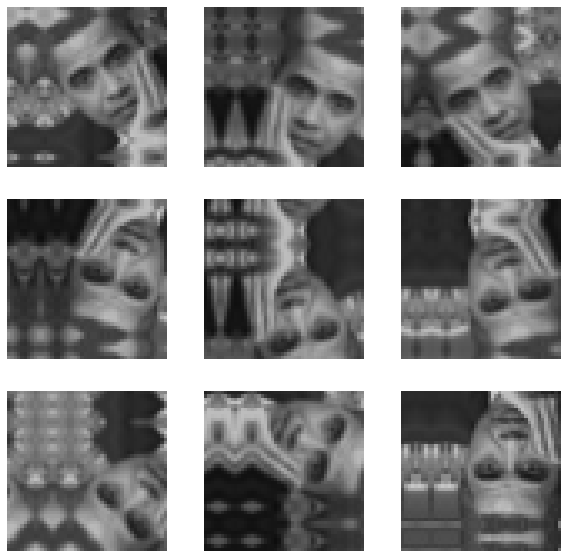

In [123]:
img1 = load_img((train_dir + 'sad' +'/'+ os.listdir(train_dir + 'sad')[1]))
re_img=tf.keras.preprocessing.image.img_to_array(img1)
plt.figure(figsize=(10,10))

for i in range(9): 
    results= rescale_layer(re_img)
    results= data_augmentation(results)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(results)
    plt.axis('off')

In [ ]:
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

model = tf.keras.models.Sequential()

#1st CNN layer
model.add(Conv2D(256,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout(0.3))

#2nd CNN layer
model.add(Conv2D(512,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout (0.3))

#3rd CNN layer
model.add(Conv2D(1024,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout (0.40))

#4th CNN layer
model.add(Conv2D(1024,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# model.add(Dropout (0.40))

model.add(Flatten())

#FC 1st layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(Dropout(0.4))


#FC 2nd layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(Dropout(0.4))

#FC 3rd layer
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(Dropout(0.4))

#FC 4th layer
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(Dropout(0.4))

#FC 5th layer
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(Dropout(0.4))

#FC 6th layer
model.add(Dense(32))
model.add(BatchNormalization())
model.add(Activation('elu'))
# model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

In [ ]:

opt = Adam(lr = 0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("./best5.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.00005,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

In [ ]:

epochs = 32

steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size


hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=100,
                 callbacks=callbacks_list,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()